# Aprendizaje supervisado con Redes Tensoriales


**Objetivo:** Construir funcion de decision $\vec{f}$ usando redes tensoriales (aqui MPS), la red se entrena usando tecnicas de optimizacion familiares al DMRG.

<center>$\vec{f}: \vec{x} \rightarrow \vec{f}(\vec{x}) \equiv \langle \vec{W} |\Phi(\vec{x}) \rangle$</center>

**'funcion de Caracteristicas':** $\Phi: \vec{x} \rightarrow |\Phi(\vec{x})\rangle:$ codifica los pixeles en escala de grises en un MPS de orden $L$, $|\Phi(\vec{x})\rangle$

**'vector de peso':** $\vec{W}: |\Phi(\vec{x})\rangle \rightarrow f^j(\vec{x}) \equiv \langle W^j |\Phi(\vec{x}) \rangle, \hspace{5mm} j=0,1,...,9$.
<br>
convierte el mapa de características en el nombre predicho a través del producto interno con un tensor MPS de orden $L$, $| W^j \rangle$

**'Nombre predicho':** La etiqueta $j$ para la cual $f^j$ es maxima

<img src="https://drive.google.com/uc?export=view&id=1irenz8ZSbCgOYMBffjN3EIb02ECRCSSR" width="300">


## Carga de datos MNIST

In [1]:
from keras.datasets import mnist
import numpy as np
import numpy.linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi, cos, sin
from ncon import ncon
#import tensornetwork
#from tensornetwork import ncon
#import tensorflow as tf
#net = tensornetwork.TensorNetwork()
#sess = tf.InteractiveSession()

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
print('Hay', X_train.shape[0], 'datos de entrenamiento y',  X_test.shape[0], 
      'datos de prueba.\nLas imagenes tienen un tamaño de', X_train.shape[1],'x',
      X_train.shape[2], 'pixeles y estan \nen una escala de grises que va de negro',
     np.amin(X_train),'a blanco',np.amax(X_train))

Hay 60000 datos de entrenamiento y 10000 datos de prueba.
Las imagenes tienen un tamaño de 28 x 28 pixeles y estan 
en una escala de grises que va de negro 0 a blanco 255


### Usaremos solo un subconjunto de los datos de prueba y entrenamiento para agiliazar los calculos

In [3]:
#Normalizamos
X_train = np.copy(X_train[:2000,:,:])/255
X_test = np.copy(X_test[:100,:,:])/255
Y_train = np.copy(Y_train[:2000])
Y_test = np.copy(Y_test[:100])


Numero de ocurrencias de cada clase de numeros:
[[  0 191]
 [  1 220]
 [  2 198]
 [  3 191]
 [  4 214]
 [  5 180]
 [  6 200]
 [  7 224]
 [  8 172]
 [  9 210]]


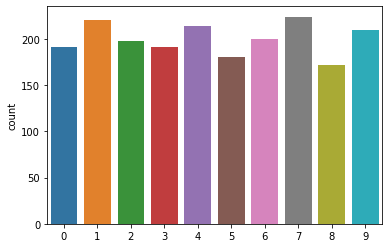

In [4]:
print('\nNumero de ocurrencias de cada clase de numeros:')
print(np.vstack((np.unique(Y_train), np.bincount(Y_train))).T)
sns.countplot(Y_train)

## Graficar primeras 36 imagenes de MNIST

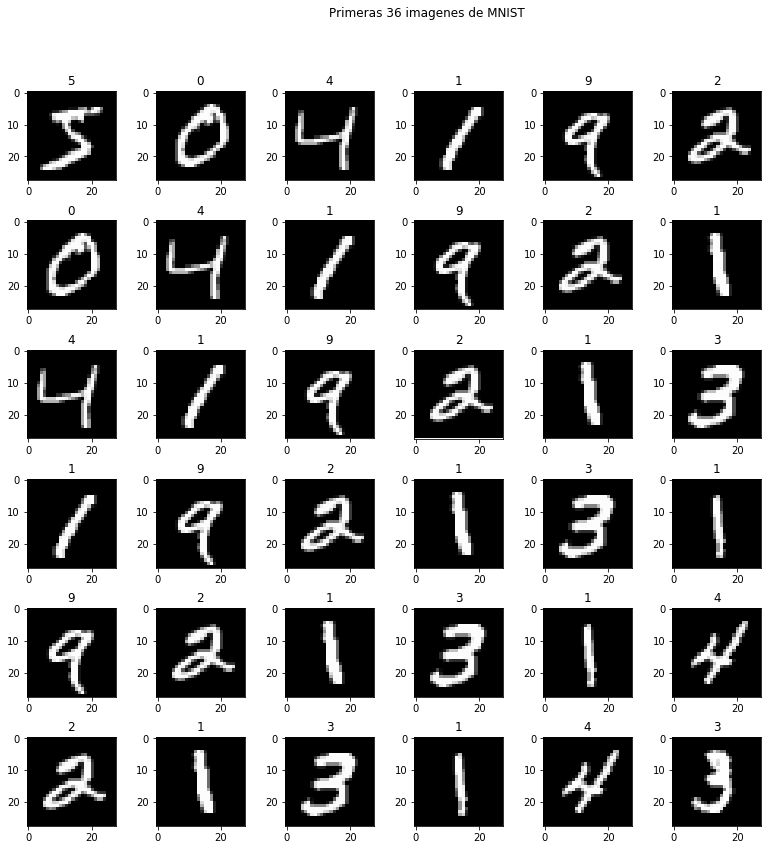

In [5]:
fig, ax = plt.subplots(6,6, figsize = (12, 12))
fig.suptitle('Primeras 36 imagenes de MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y], cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y])

### En el articulo de Stoudenmire, el tamaño de las imagenes son reducidas (Coarse-graining) un factor de 2. Al hacer esto, podremos usar un MPS mas pequeño de longitud $14² = 196$

In [6]:
from skimage.transform import rescale

l = []

for i in range(len(X_train)):
    l.append(rescale(X_train[i,:,:], 0.5, anti_aliasing=True,multichannel=False))

r = []

for i in range(len(X_test)):
    r.append(rescale(X_test[i,:,:], 0.5, anti_aliasing=True,multichannel=False))

X_train = np.array(l)
X_test = np.array(r)

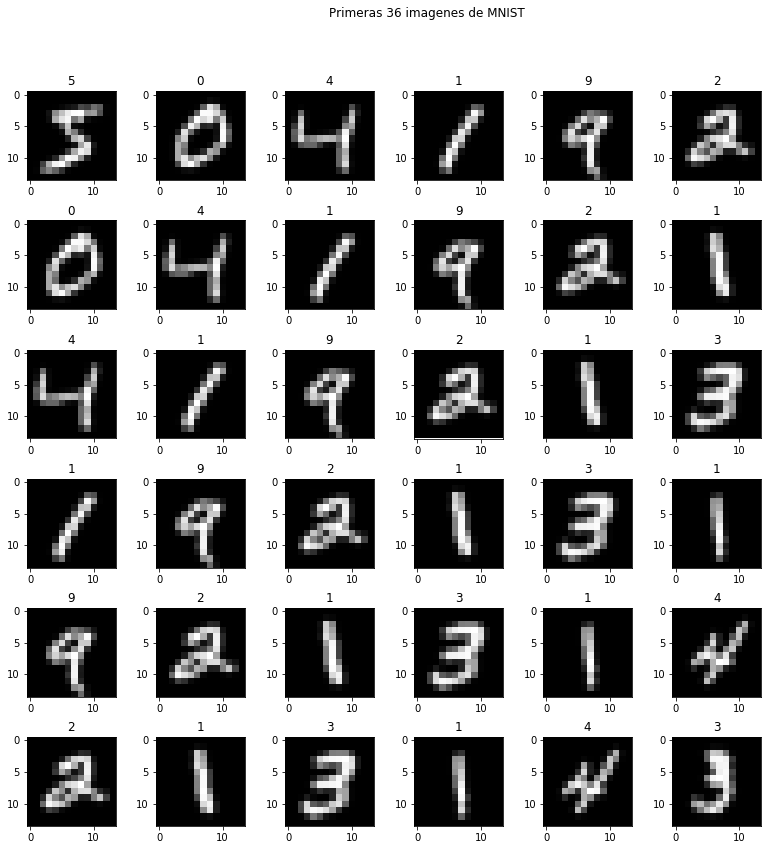

In [7]:
fig, ax = plt.subplots(6,6, figsize = (12, 12))
fig.suptitle('Primeras 36 imagenes de MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y], cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y])

### Las primeras 36 imagenes estan etiquetadas como:

In [8]:
Y_train[:36]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5], dtype=uint8)

### Representacion en One-Hot encoding de las etiquetas 

In [9]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [10]:
print(Y_train.shape)

(2000, 10)


In [11]:
print(Y_train[0:35])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0.

In [12]:
Y_train.shape

(2000, 10)

## Generar vectores de caracteristicas

Los pixeles son mapeados individualmente a vectores bidimensionales llamados vectores de caracteristicas.

En el articulo de Stoudenmire proveen la correspondencia uno a uno entre un pixel y un vector

<img src="https://drive.google.com/uc?export=view&id=1F5_xJq48sTkkVfYn8k360G5A2_PWGDPo" width="400">

Ésta contruccion de $|\Phi(\vec{x})\rangle$ no es unica. Otras construcciones son posibles siempre que $\langle\Phi(\vec{x})|\Phi(\vec{x})\rangle$ sea una función de $\vec{x}$ y $\vec{x}'$ que varía suave y lentamente que induce una 'matriz de distancia' en el espacio de características que tiende a agrupar imágenes similares.

#### Ordenamiento de los pixeles en forma de serpiente

In [13]:
print(X_train[0,2,:])
print('\n',X_train[0,5,:])

[0.00000000e+00 0.00000000e+00 3.34471991e-09 3.53842760e-04
 7.34188983e-03 2.58936966e-02 6.23101060e-02 9.47000623e-02
 2.75636919e-01 2.28260078e-01 4.05123576e-01 3.43192753e-01
 1.26425823e-02 0.00000000e+00]

 [0.00000000e+00 0.00000000e+00 1.22867262e-09 9.10939663e-04
 3.44749235e-02 3.20009108e-01 7.30330897e-01 4.12189845e-02
 1.85557693e-02 1.72725877e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [14]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        if j%2==0:
            continue
        else:
            X_train[i,j,::1] = X_train[i,j,::-1]

In [15]:
print(X_train[0,2,:])
print('\n',X_train[0,5,:])

[0.00000000e+00 0.00000000e+00 3.34471991e-09 3.53842760e-04
 7.34188983e-03 2.58936966e-02 6.23101060e-02 9.47000623e-02
 2.75636919e-01 2.28260078e-01 4.05123576e-01 3.43192753e-01
 1.26425823e-02 0.00000000e+00]

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.72725877e-03 1.85557693e-02 4.12189845e-02 7.30330897e-01
 3.20009108e-01 3.44749235e-02 9.10939663e-04 1.22867262e-09
 0.00000000e+00 0.00000000e+00]


## vectores de caracteristicas

In [16]:
#Normalizacion
X_train = X_train*(pi/2)
X_test = X_test*(pi/2)

In [17]:
F_train = []
l = []

for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            a = np.concatenate((cos(X_train[i,j,k]),sin(X_train[i,j,k])),axis=None)
            l.append(a)
    F_train.append(l)
    l = []

# F_train[m][n] es el vector de caracteristicas bidimensional para el n-esimo pixel
# de la m-esima imagen
    
F_test = []
p = []

for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            a = np.concatenate((cos(X_test[i,j,k]),sin(X_test[i,j,k])),axis=None)
            p.append(a)
    F_test.append(p)
    p = []
    
F_train = np.array(F_train)
F_test = np.array(F_test)

## Vector de peso: codificar el patron de reconocimiento

#### Inicializar MPS 

In [18]:
Nkeep = 20 # dimension interna
chid = 2 # dimension local
label = Y_train.shape[1] # numero de etiquetas

# orden de los indices de M[itm < 195]: left - physical (= feature vector) - right
# orden de los indices de M[195]: left - physical - right - labels
M = [0 for x in range(X_train.shape[1]**2)] # lista de tensores de la red MPS
M[0] = np.random.rand(1,chid,Nkeep)
M[X_train.shape[1]**2-1] = np.random.rand(Nkeep,chid,1,label)
for k in range(1,X_train.shape[1]**2-1):
    M[k] = np.random.rand(Nkeep,chid,Nkeep)


#### Llevar a forma canonica a izquierda

In [19]:
for p in range(len(M)-1):
    chil = M[p].shape[0]; chir = M[p].shape[2]
    utemp, stemp, vhtemp = LA.svd(M[p].reshape(chil*chid,chir), full_matrices=False)
    chis = stemp.shape[0]
    M[p] = utemp.reshape(chil,chid,chis)
    if p <= len(M)-3:
        M[p+1] = ncon([np.diag(stemp),vhtemp,M[p+1]], [[-1,1],[1,2],[2,-2,-3]])/LA.norm(stemp)
    else:
        M[p+1] = ncon([np.diag(stemp),vhtemp,M[p+1]], [[-1,1],[1,2],[2,-2,-3,-4]])/LA.norm(stemp)
    

In [20]:
print(M[0] @ M[0].T)

[[[ 1.00000000e+00]
  [-5.55111512e-17]]

 [[-5.55111512e-17]
  [ 1.00000000e+00]]]


## Aprendizaje de maquina con MPS

In [21]:
# Verificar input
if len(F_train) != len(Y_train):
    print('ERR: # de datos de entrenamiento en F e y es inconsistente.')
elif len(F_test) != len(Y_test):
    print('ERR: # de datos de prueba en F e y es inconsistente.')
elif Y_train.shape[1] != Y_test.shape[1]:
    print('ERR: # de etiquetas para los datos de entrenamiento y prueba es inconsistente.')

In [22]:
# matrices de resultados
estep = np.linspace(0.1, 0.5, 5)

cfun = np.zeros((len(M),2*len(estep))) # función de costo para datos de entrenamiento
err = np.zeros((len(M),2*len(estep))) # tasa de error para datos de entrenamiento
cfun_test = np.zeros((len(M),2*len(estep))) # función de costo para datos de prueba
err_test = np.zeros((len(M),2*len(estep))) # tasa de error para datos de prueba

In [23]:
print('Aprendizaje automático usando MPS\n')
print('  Longitud = ',len(M),', # datos de entrenamiento = ',len(F_train),', # datos prueba = '
      ,len(F_test),'\n')
print('  # etiquetas = ', Y_train.shape[1],', Nkeep = ',Nkeep,', {} barridos\n'.format(2*len(estep)))


Aprendizaje automático usando MPS

  Longitud =  196 , # datos de entrenamiento =  2000 , # datos prueba =  100 

  # etiquetas =  10 , Nkeep =  20 , 10 barridos



In [24]:
## actualizar vectores de características en la base efectiva 

Nsites = len(M)
L = [0 for x in range(Nsites-2)]; 
R = [0 for x in range(Nsites-2)];

#para datos entrenamiento
Flr = []
l = []

import time
start1 = time.time()

for i in range(len(F_train)):
    for j in range(Nsites-2):
        if j == 0:
            L[j] = ncon([F_train[i,j,:],M[j]],[[1],[-1,1,-2]])
            l.append(L[j])
        else:
            L[j] = ncon([L[j-1],M[j],F_train[i,j,:]],[[-1,1],[1,2,-2],[2]])
            l.append(L[j])
    Flr.append(l)
    l = []

end1 = time.time()
print(end1 - start1)


400.11908078193665


In [68]:
len(Flr)

2000

In [62]:
#para datos de prueba

Flrt = []
p = []

start2 = time.time()

for i in range(len(F_test)):
    for j in range(Nsites-2):
        if j == 0:
            L[j] = ncon([F_test[i,j,:],M[j]],[[1],[-1,1,-2]])
            p.append(L[j])
        else:
            L[j] = ncon([L[j-1],M[j],F_test[i,j,:]],[[-1,1],[1,2,-2],[2]])
            p.append(L[j])
    Flrt.append(p)
    p = []

end2 = time.time()
print(end2 - start2)

19.150498867034912


In [67]:
len(Flrt)

100

In [55]:
#Lista de tensores de borde de todas las imagenes 

#para datos de entrenamiento
Flr_train = []
l = []

for j in range(Nsites-2):
    for i in range(len(F_train)):
        l.append(Flr[i][j])
    Flr_train.append(np.array(l))
    l = []

0.8245503902435303


In [73]:
len(Flr_train)

194

In [61]:
Flr_train[0].shape

(2000, 1, 2)

In [79]:
Flr_train[193].shape

(2000, 1, 20)

In [69]:
#para datos de prueba
Flr_test = []
l = []

for j in range(Nsites-2):
    for i in range(len(F_test)):
        l.append(Flrt[i][j])
    Flr_test.append(np.array(l))
    l = []

0.040644168853759766


In [74]:
len(Flr_test)

194

In [70]:
Flr_test[0].shape

(100, 1, 2)

In [ ]:
Flr_test[194].shape

In [99]:
for p in range(7-2,2,-1):
    print(p)

5
4
3


In [100]:
len(M)-2

194

In [ ]:
#Comenzar el barrido

for its in range(len(estep)):
    for p in range(len(M)-2,2,-1):
        

In [ ]:
disptime('Start sweeping');

for its = (1:numel(estep))
    # left <- right
    for itn = (numel(M):-1:2)
        B = contract(M{itn-1},3,3,M{itn},4,1);
        # leg order of M{itn-1}: left-physical-right
        # leg order of M{itn}: left-physical-right-label
        # leg order of B: left-physical(itn-1)-physical(itn)-right-label
        
        # for test data, compute only cost function and error rate
        [cfun_test(end+1-itn,2*its-1),err_test(end+1-itn,2*its-1)] = ...
            ML_MPS_1step (B,Flr_test{itn-1},F_test(:,:,itn-1),F_test(:,:,itn),Flr_test{itn+2},y_test);
        
        # compute cost function, error rate, gradient of B
        [cfun(end+1-itn,2*its-1),err(end+1-itn,2*its-1),dB] = ...
            ML_MPS_1step (B,Flr{itn-1},F(:,:,itn-1),F(:,:,itn),Flr{itn+2},y);

        # update B tensor
        B = B + dB*estep(its);
        
        # SVD and update M{itn-1}, M{itn}
        [M{itn-1},S,M{itn}] = svdTr(B,5,[1 2 5],Nkeep,[]); % associate the label leg with M{itn-1}
        S = S/norm(S); % normalize
        M{itn-1} = contract(M{itn-1},4,4,diag(S),2,1,[1 2 4 3]); % leg order: left-physical-right-label
        
        # update Flr{itn+1} in accordance with the updated M{itn}
        T = permute(M{itn},[3 2 1]);
        T = reshape(T,[1 size(T)]);
        if ~isempty(Flr{itn+2})
            T = sum(bsxfun(@times,T,Flr{itn+2}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F(:,:,itn),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn+1}
        Flr{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
        
        # update Flr_test{itn+1} in accordance with the updated M{itn}
        T = permute(M{itn},[3 2 1]);
        T = reshape(T,[1 size(T)]);
        if ~isempty(Flr_test{itn+2})
            T = sum(bsxfun(@times,T,Flr_test{itn+2}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F_test(:,:,itn),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn+1}
        Flr_test{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
    end
    
    disptime(['Sweep #',sprintf('%02i/%02i',2*its-1,2*numel(estep)), ...
        ' | left <- right,  eta = ',sprintf('%.3g',estep(its))]);
    fprintf(['  Training: cost fun = ',sprintf('%.3e',cfun(numel(M)-1,2*its-1)), ...
        ', error rate = ',sprintf('%5.3e',err(numel(M)-1,2*its-1)),'\n']);
    fprintf(['     Test : cost fun = ',sprintf('%.3e',cfun_test(numel(M)-1,2*its-1)), ...
        ', error rate = ',sprintf('%.3e',err_test(numel(M)-1,2*its-1)),'\n']);

    # left -> right
    for itn = (2:numel(M))
        B = contract(M{itn-1},4,3,M{itn},3,1,[1 2 4 5 3]);
        # leg order of M{itn-1}: left-physical-right-label
        # leg order of M{itn}: left-physical-right
        # leg order of B: left-physical(itn-1)-physical(itn)-right-label
        
        # for test data, compute only cost function and error rate
        [cfun_test(itn-1,2*its),err_test(itn-1,2*its)] = ...
            ML_MPS_1step (B,Flr_test{itn-1},F_test(:,:,itn-1),F_test(:,:,itn),Flr_test{itn+2},y_test);

        # compute cost function, error rate, gradient
        [cfun(itn-1,2*its),err(itn-1,2*its),dB] = ...
            ML_MPS_1step (B,Flr{itn-1},F(:,:,itn-1),F(:,:,itn),Flr{itn+2},y);

        # update B tensor
        B = B + dB*estep(its);
        
        # SVD and update M{itn-1}, M{itn}
        [M{itn-1},S,M{itn}] = svdTr(B,5,[1 2],Nkeep,[]); % associate the label leg with M{itn}
        S = S/norm(S); % normalize
        M{itn} = contract(diag(S),2,2,M{itn},4,1); % leg order: left-physical-right-label
        
        # update Flr{itn} in accordance with the updated M{itn-1}
        T = reshape(M{itn-1},[1 size(M{itn-1})]);
        if ~isempty(Flr{itn-1})
            T = sum(bsxfun(@times,T,Flr{itn-1}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F(:,:,itn-1),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn}
        Flr{itn} = bsxfun(@rdivide,T,max(abs(T),[],2));
        
        # update Flr_test{itn} in accordance with the updated M{itn-1}
        T = reshape(M{itn-1},[1 size(M{itn-1})]);
        if ~isempty(Flr_test{itn-1})
            T = sum(bsxfun(@times,T,Flr_test{itn-1}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F_test(:,:,itn-1),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr_test{itn}
        Flr_test{itn} = bsxfun(@rdivide,T,max(abs(T),[],2));
    end
    
    disptime(['Sweep #',sprintf('%02i/%02i',2*its,2*numel(estep)), ...
        ' | left -> right,  eta = ',sprintf('%.3g',estep(its))]);
    fprintf(['  Training: cost fun = ',sprintf('%.3e',cfun(numel(M)-1,2*its)), ...
        ', error rate = ',sprintf('%5.3e',err(numel(M)-1,2*its)),'\n']);
    fprintf(['     Test : cost fun = ',sprintf('%.3e',cfun_test(numel(M)-1,2*its)), ...
        ', error rate = ',sprintf('%.3e',err_test(numel(M)-1,2*its)),'\n']);
end

toc2(tobj,'-v');
chkmem;

end


In [ ]:
function [cfun,err,varargout] = ML_MPS_1step (B,F1,F2,F3,F4,y)
# < Description >
#
# [cfun,err,varargout] = ML_MPS_1step (B,F1,F2,F3,F4,y)
#
# < Input >
# B : [rank-5 tensor] The contraction of two local tensors of the MPS,
#       associated with the current orthogonality center.
# F1, F2, F3, F4 : [tensors] Feature vector data. F2 and F3 are local
#       feature vectors at two sites associated with the current
#       orthogonality center. F1 (F4) is the contraction of feature vectors
#       at the left (right) parts of chain with the MPS tensors; F1 and F4
#       are the feature vectors in effective basis.
# y : [matrix] Collection of correct decision functions.
#
# < Output >
# cfun, err : [numeric] Cost function per dataset and error rate of
#       predicting labels, respectively. 
# dB : (Optional) [rank-5 tensor] Gradient for the B tensor.

####### TODO - Exercise 1   (Start) #########
## evaluate decision function f^l (x) in Eq. (6) of Stoudenmire2016

# Goal: generate matrix fx, such that fx(n,l) means f^l (x_n)

# insert one dimension (leg) to the front, which corresponds to
# data set indices
fx = reshape(B,[1 size(B)]);
if ~isempty(F1)
    fx = sum(bsxfun(@times,fx,F1),2);
end
fx = permute(fx,[1 (3:6) 2]); % put the singleton dimension at the end
fx = sum(bsxfun(@times,fx,F2),2);
fx = permute(fx,[1 (3:5) 2]);
fx = sum(bsxfun(@times,fx,F3),2);
fx = permute(fx,[1 3 4 2]);
if ~isempty(F4)
    fx = sum(bsxfun(@times,fx,F4),2);
end
fx = permute(fx,[1 3 2]);
#####  TODO - Exercise 1   (End) #######

In [ ]:
# measure error rate of descision function
[~,maxid] = max(fx,[],2);
err = 1 - sum(y((1:size(fx,1)).'+(maxid-1)*size(fx,1)))/size(fx,1);

# deviation of the decision function from the correct value;
# y_n^l - f^l (x_n) in Fig. 6(d) of Stoudenmire2016
ydiff = y - fx; 

# cost function per data set
cfun = sum(abs(ydiff(:)).^2)/2/size(y,1);

In [ ]:
if nargout > 2
    ####### TODO - Exercise 1   (Start) ########
    ## compute the gradient \Delta B in Eq. (7) of Stoudenmire2016
    
    # Goal: generate rank-5 tensor dB that corresponds to \Delta B
    dB = reshape(ydiff,[size(ydiff,1) ones(1,4) size(ydiff,2)]);
    if ~isempty(F1)
        dB = bsxfun(@times,dB,F1);
    end
    dB = bsxfun(@times,dB,reshape(F2,[size(F2,1) 1 size(F2,2)]));
    dB = bsxfun(@times,dB,reshape(F3,[size(F3,1) 1 1 size(F3,2)]));
    if ~isempty(F4)
        dB = bsxfun(@times,dB,reshape(F4,[size(F4,1) ones(1,3) size(F4,2)]));
    end
    # use mean, instead of sum, to compute dB
    dB = mean(dB,1);
    dB = permute(dB,[(2:6) 1]);
    ####### TODO - Exercise 1   (End) ######
    
    varargout{1} = dB;
end

end


In [ ]:
def ML_MPS(M,F,y,F_test,y_test,Nkeep,estep):
""" < Descripcion >

 Metodo de aprendizaje de maquina basado enmatrix product state (MPS), propuesto por
 Stoudenmire2016 [E. M. Stoudenmire and D. J. Schwab, Adv. Neur. In. 29,
 4799 (2016), or arXiv:1605.05775].

 < Input >
 M : [lista de tensores de orden 3] Cada celda contiene un tensor de orden 3
      para cada sitio de la cadena (MPS)
 F : [lista de listas con tensores de orden 1] Coleccion de vectores de 
       caracteristicas para datos de entrenamiento. F_train[m][n] es el 
       vector de caracteristicas bidimensional para el n-esimo pixel de 
       la m-esima imagen. 
 y : [matriz] Coleccion de funciones de decision correctas para los datos 
      de entrenamiento y(m,n) es 1 si el m-esimo dato (i.e. imagen) esta
      etiquetado por la n-esima etiqueta, 0 de otra manera.
 F_test : [lista de listas con tensores de orden 1] Coleccion de vectores de
           caracteristicas para datos de prueba
 y_test : [matriz] Coleccion de funciones de decision correctas para los 
           datos de prueba
 Nkeep : [entero] dimension de enlace maxima para el MPS.
 estep : [vector] \eta en Sec. 4 deStoudenmire2016. La longitud de estep 
          define el numero de barridos; habran 2*len(estep) barridos. 
          cada valor, estep[m], se aplica al m-ésimo par de barridos.

 < Output >
 M : [lista de tensores de orden 3] MPS optimizado despues de los barridos.
 cfun : [matriz] Registro de funciones de costo medido (consulte el segundo 
         párrafo de la Sección 4 de Stoudenmire2016) por conjunto de datos 
         en cada iteración, para el conjunto de datos de entrenamiento. Su 
         n-ésima columna corresponde al n-ésimo barrido. Los valores se 
         registran siguiendo el orden de indexación Python. Es 
         decir, cfun[:,n] contiene los valores en el orden de las ocurrencias.
 err : [matriz] Registro de tasas de error para predecir etiquetas correctas 
        en cada iteración, para el conjunto de datos de entrenamiento. 
        'err' sigue la misma indexación que 'cfun'.
 cfun_test : [matriz] Registro de funciones de costo medido para el conjunto 
              de datos de prueba.
 err_test : [matriz] Registro de la tasa de error de las etiquetas de 
             predicción para el conjunto de datos de prueba.

"""

# Verificar input
if len(F) != len(y):
    print('ERR: # de datos de entrenamiento en F e y es inconsistente.')
elif len(F_test) != len(y_test):
    print('ERR: # de datos de prueba en F e y es inconsistente.')
elif y.shape[1] != y_test.shape[1]:
    print('ERR: # de etiquetas para los datos de entrenamiento y prueba es inconsistente.')

# matrices de resultados
cfun = np.zeros((len(M),2*len(estep))) # función de costo para datos de entrenamiento
err = np.zeros((len(M),2*len(estep))) # tasa de error para datos de entrenamiento
cfun_test = np.zeros((len(M),2*len(estep))) # función de costo para datos de prueba
err_test = np.zeros((len(M),2*len(estep))) # tasa de error para datos de prueba

print('Aprendizaje automático usando MPS\n')
print('  Length = ',len(M),', # datos de entrenamiento = ',len(F),', # datos prueba = '
      ,len(F_test),'\n')
print('  # etiquetas = ', y.shape[1],', Nkeep = ',Nkeep,', {} barridos\n'.format(2*len(estep)))

## actualizar vectores de características en la base efectiva 

# para datos de entrenamiento
Flr = [0 for x in range(len(M)+2)]

for itn in range(len(M)-2): # omita los dos últimos sitios, ya que no se utilizará Flr para ellos
    T = M[itn].reshape(1 size(M{itn})]);
    if Flr[itn] != 0:
        T = sum(bsxfun(@times,T,Flr{itn}),2);
    end
    T = permute(T,[1 3 4 2]); # put the singleton dimension at the end
    T = sum(bsxfun(@times,T,F(:,:,itn)),2);
    T = permute(T,[1 3 2]); # put the singleton dimension at the end
    
    # rescale and assign to Flr{itn+1}
    Flr{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
#     Flr{itn+1} = bsxfun(@rdivide,T,sqrt(sum(abs(T).^2,2)));
end

# for test data
Flr_test = cell(1,numel(M)+2);

for itn = (1:(numel(M)-2)) % skip last two sites, since Flr for them will not be used
    T = reshape(M{itn},[1 size(M{itn})]);
    if ~isempty(Flr_test{itn})
        T = sum(bsxfun(@times,T,Flr_test{itn}),2);
    end
    T = permute(T,[1 3 4 2]); % put the singleton dimension at the end
    T = sum(bsxfun(@times,T,F_test(:,:,itn)),2);
    T = permute(T,[1 3 2]); % put the singleton dimension at the end

    # rescale and assign to Flr{itn+1}
    Flr_test{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
#     Flr_test{itn+1} = bsxfun(@rdivide,T,sqrt(sum(abs(T).^2,2)));
end

disptime('Start sweeping');

for its = (1:numel(estep))
    # left <- right
    for itn = (numel(M):-1:2)
        B = contract(M{itn-1},3,3,M{itn},4,1);
        # leg order of M{itn-1}: left-physical-right
        # leg order of M{itn}: left-physical-right-label
        # leg order of B: left-physical(itn-1)-physical(itn)-right-label
        
        # for test data, compute only cost function and error rate
        [cfun_test(end+1-itn,2*its-1),err_test(end+1-itn,2*its-1)] = ...
            ML_MPS_1step (B,Flr_test{itn-1},F_test(:,:,itn-1),F_test(:,:,itn),Flr_test{itn+2},y_test);
        
        # compute cost function, error rate, gradient of B
        [cfun(end+1-itn,2*its-1),err(end+1-itn,2*its-1),dB] = ...
            ML_MPS_1step (B,Flr{itn-1},F(:,:,itn-1),F(:,:,itn),Flr{itn+2},y);

        # update B tensor
        B = B + dB*estep(its);
        
        # SVD and update M{itn-1}, M{itn}
        [M{itn-1},S,M{itn}] = svdTr(B,5,[1 2 5],Nkeep,[]); % associate the label leg with M{itn-1}
        S = S/norm(S); % normalize
        M{itn-1} = contract(M{itn-1},4,4,diag(S),2,1,[1 2 4 3]); % leg order: left-physical-right-label
        
        # update Flr{itn+1} in accordance with the updated M{itn}
        T = permute(M{itn},[3 2 1]);
        T = reshape(T,[1 size(T)]);
        if ~isempty(Flr{itn+2})
            T = sum(bsxfun(@times,T,Flr{itn+2}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F(:,:,itn),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn+1}
        Flr{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
        
        # update Flr_test{itn+1} in accordance with the updated M{itn}
        T = permute(M{itn},[3 2 1]);
        T = reshape(T,[1 size(T)]);
        if ~isempty(Flr_test{itn+2})
            T = sum(bsxfun(@times,T,Flr_test{itn+2}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F_test(:,:,itn),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn+1}
        Flr_test{itn+1} = bsxfun(@rdivide,T,max(abs(T),[],2));
    end
    
    disptime(['Sweep #',sprintf('%02i/%02i',2*its-1,2*numel(estep)), ...
        ' | left <- right,  eta = ',sprintf('%.3g',estep(its))]);
    fprintf(['  Training: cost fun = ',sprintf('%.3e',cfun(numel(M)-1,2*its-1)), ...
        ', error rate = ',sprintf('%5.3e',err(numel(M)-1,2*its-1)),'\n']);
    fprintf(['     Test : cost fun = ',sprintf('%.3e',cfun_test(numel(M)-1,2*its-1)), ...
        ', error rate = ',sprintf('%.3e',err_test(numel(M)-1,2*its-1)),'\n']);

    # left -> right
    for itn = (2:numel(M))
        B = contract(M{itn-1},4,3,M{itn},3,1,[1 2 4 5 3]);
        # leg order of M{itn-1}: left-physical-right-label
        # leg order of M{itn}: left-physical-right
        # leg order of B: left-physical(itn-1)-physical(itn)-right-label
        
        # for test data, compute only cost function and error rate
        [cfun_test(itn-1,2*its),err_test(itn-1,2*its)] = ...
            ML_MPS_1step (B,Flr_test{itn-1},F_test(:,:,itn-1),F_test(:,:,itn),Flr_test{itn+2},y_test);

        # compute cost function, error rate, gradient
        [cfun(itn-1,2*its),err(itn-1,2*its),dB] = ...
            ML_MPS_1step (B,Flr{itn-1},F(:,:,itn-1),F(:,:,itn),Flr{itn+2},y);

        # update B tensor
        B = B + dB*estep(its);
        
        # SVD and update M{itn-1}, M{itn}
        [M{itn-1},S,M{itn}] = svdTr(B,5,[1 2],Nkeep,[]); % associate the label leg with M{itn}
        S = S/norm(S); % normalize
        M{itn} = contract(diag(S),2,2,M{itn},4,1); % leg order: left-physical-right-label
        
        # update Flr{itn} in accordance with the updated M{itn-1}
        T = reshape(M{itn-1},[1 size(M{itn-1})]);
        if ~isempty(Flr{itn-1})
            T = sum(bsxfun(@times,T,Flr{itn-1}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F(:,:,itn-1),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr{itn}
        Flr{itn} = bsxfun(@rdivide,T,max(abs(T),[],2));
        
        # update Flr_test{itn} in accordance with the updated M{itn-1}
        T = reshape(M{itn-1},[1 size(M{itn-1})]);
        if ~isempty(Flr_test{itn-1})
            T = sum(bsxfun(@times,T,Flr_test{itn-1}),2);
        end
        T = permute(T,[1 3 4 2]);
        T = sum(bsxfun(@times,F_test(:,:,itn-1),T),2);
        T = permute(T,[1 3 2]);
        # rescale and assign to Flr_test{itn}
        Flr_test{itn} = bsxfun(@rdivide,T,max(abs(T),[],2));
    end
    
    disptime(['Sweep #',sprintf('%02i/%02i',2*its,2*numel(estep)), ...
        ' | left -> right,  eta = ',sprintf('%.3g',estep(its))]);
    fprintf(['  Training: cost fun = ',sprintf('%.3e',cfun(numel(M)-1,2*its)), ...
        ', error rate = ',sprintf('%5.3e',err(numel(M)-1,2*its)),'\n']);
    fprintf(['     Test : cost fun = ',sprintf('%.3e',cfun_test(numel(M)-1,2*its)), ...
        ', error rate = ',sprintf('%.3e',err_test(numel(M)-1,2*its)),'\n']);
end

toc2(tobj,'-v');
chkmem;

end


function [cfun,err,varargout] = ML_MPS_1step (B,F1,F2,F3,F4,y)
# < Description >
#
# [cfun,err,varargout] = ML_MPS_1step (B,F1,F2,F3,F4,y)
#
# < Input >
# B : [rank-5 tensor] The contraction of two local tensors of the MPS,
#       associated with the current orthogonality center.
# F1, F2, F3, F4 : [tensors] Feature vector data. F2 and F3 are local
#       feature vectors at two sites associated with the current
#       orthogonality center. F1 (F4) is the contraction of feature vectors
#       at the left (right) parts of chain with the MPS tensors; F1 and F4
#       are the feature vectors in effective basis.
# y : [matrix] Collection of correct decision functions.
#
# < Output >
# cfun, err : [numeric] Cost function per dataset and error rate of
#       predicting labels, respectively. 
# dB : (Optional) [rank-5 tensor] Gradient for the B tensor.

####### TODO - Exercise 1   (Start) #########
## evaluate decision function f^l (x) in Eq. (6) of Stoudenmire2016

# Goal: generate matrix fx, such that fx(n,l) means f^l (x_n)

# insert one dimension (leg) to the front, which corresponds to
# data set indices
fx = reshape(B,[1 size(B)]);
if ~isempty(F1)
    fx = sum(bsxfun(@times,fx,F1),2);
end
fx = permute(fx,[1 (3:6) 2]); % put the singleton dimension at the end
fx = sum(bsxfun(@times,fx,F2),2);
fx = permute(fx,[1 (3:5) 2]);
fx = sum(bsxfun(@times,fx,F3),2);
fx = permute(fx,[1 3 4 2]);
if ~isempty(F4)
    fx = sum(bsxfun(@times,fx,F4),2);
end
fx = permute(fx,[1 3 2]);
#####  TODO - Exercise 1   (End) #######


# measure error rate of descision function
[~,maxid] = max(fx,[],2);
err = 1 - sum(y((1:size(fx,1)).'+(maxid-1)*size(fx,1)))/size(fx,1);

# deviation of the decision function from the correct value;
# y_n^l - f^l (x_n) in Fig. 6(d) of Stoudenmire2016
ydiff = y - fx; 

# cost function per data set
cfun = sum(abs(ydiff(:)).^2)/2/size(y,1);

if nargout > 2
    ####### TODO - Exercise 1   (Start) ########
    ## compute the gradient \Delta B in Eq. (7) of Stoudenmire2016
    
    # Goal: generate rank-5 tensor dB that corresponds to \Delta B
    dB = reshape(ydiff,[size(ydiff,1) ones(1,4) size(ydiff,2)]);
    if ~isempty(F1)
        dB = bsxfun(@times,dB,F1);
    end
    dB = bsxfun(@times,dB,reshape(F2,[size(F2,1) 1 size(F2,2)]));
    dB = bsxfun(@times,dB,reshape(F3,[size(F3,1) 1 1 size(F3,2)]));
    if ~isempty(F4)
        dB = bsxfun(@times,dB,reshape(F4,[size(F4,1) ones(1,3) size(F4,2)]));
    end
    # use mean, instead of sum, to compute dB
    dB = mean(dB,1);
    dB = permute(dB,[(2:6) 1]);
    ####### TODO - Exercise 1   (End) ######
    
    varargout{1} = dB;
end

end
